# Proximity tools

In this tutorial, you'll learn how to use [Xarray-Spatial's proximity toolset](https://xarray-spatial.org/user_guide/proximity.html) to measure distances between points. You'll analyze water level data for the Amazon rainforest around Oriximiná, Brazil, from the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw).

Xarray-Spatial offers three proximity tools:
* [Proximity Distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html): for each point in the input raster, this tool calculates the distance to the nearest of a set of target points or source points.
* [Proximity Allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html): for each cell in the input raster, this tool identifies the nearest source or target point (the 'allocation' point).
* [Proximity Direction](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.direction.html): for each cell in the input raster, this tool returns the direction to the nearest source point (the 'allocation').

These proximity tools support the following three metrics to measure distances:
* [Euclidean distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.euclidean_distance.html): a straight-line distance between two points
* [Manhattan distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.manhattan_distance.html): a distance that considers obstacles in the path, also known as 'taxicab' metric
* [Great-circle distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.great_circle_distance.html): a distance across the surface of a sphere instead of a plane

This tutorial walks you through:
1. [Loading and preparing](#Prepare-and-load-the-data) the Global Surface Water Dataset
2. [Computing Proximity Distance](#Proximity-Distance): Analyze the Global Surface Water Dataset's Maximum Water Extent data to calculate proximity distances in relation to all points that were detected as water. 
3. [Computing Proximity Allocation](#Proximity-Allocation): Analyze the Global Surface Water Dataset's Transitions data to calculate proximity allocations between areas of different water transitions.
4. [Computing Proximity Direction](#Proximity-Direction): Analyze the Global Surface Water Dataset's Water Seasonality data to calculate the proximity direction of areas where surface water is present for more than three-quarters of the year.

In [1]:
import pystac_client
import rasterio
import rasterio.mask
import numpy as np
import planetary_computer as pc
import stackstac

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

from xrspatial import proximity, allocation, direction

## Prepare and load the data

This example uses a small amount of data. Set up a local Dask "cluster" on a single machine:


In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You'll analyze a small area in the Amazon rainforest located around Oriximiná, State of Pará, Brazil. The region of interest contains parts of the Amazon River and smaller rivers such as the Nhamundá River, Trombetas River, and Paru de Oeste River. 

Use `pystac-client` to find all [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/overview.md#item-overview) covering that area:

In [3]:
bounds = [-57.151965, -2.530125, -55.710724, -1.179033]

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
jrc = catalog.search(collections=["jrc-gsw"], bbox=bounds)

items = list(jrc.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [4]:
item = items[0]
item

<Item id=60W_0Nv1_3_2020>

This notebook uses these three assets of the dataset: Maximum Water Extent, Water Seasonality, and Water Transitions. Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load the item data, select the desired assets, and crop the area to our bounds of interest. All of those three operations happen at the same time. See the [jrc-gsw example notebook](../datasets/jrc-gsw/jrc-gsw-example.ipynb) to learn more about how to use this dataset.

In [5]:
assets_of_interest = ["extent", "seasonality", "transitions"]

data = (
    stackstac.stack(
        [pc.sign(item).to_dict()],
        assets=assets_of_interest,
        bounds=bounds,
        chunksize=3000,
    )
    .isel(time=0)
    .persist()
)

data

<xarray.DataArray 'stackstac-5c440c7d09ea55e7bc47bd5d81def35e' (band: 3, y: 5405, x: 5766)>
dask.array<getitem, shape=(3, 5405, 5766), dtype=float64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
  * band            (band) <U11 'extent' 'seasonality' 'transitions'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    sci:doi         <U19 '10.1038/nature20584'
    ...              ...
    proj:transform  object {0.0, -0.00025, -60.0, 0.00025}
    start_datetime  (band) object None '2020-01-01T00:00:00Z' None
    proj:epsg       int64 4326
    description     (band) <U74 'Binary indicator of whether water was ever p...
    title           (band) <U20 'Maximum Water Extent' ... 'Transitions'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

The JRC Global Surface Water COGs include colormaps for each of the assets. Use the [open](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function of [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) to read the GeoTIFFs' metadata and select the three colormaps for the assets you are working with. Before you can use those colormaps, you need to convert them into matplotlib [ListedColormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) objects:

In [6]:
cmaps = {}

for asset_key in assets_of_interest:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

Next, visualize the data using the corresponding colormap for each of the three assets:

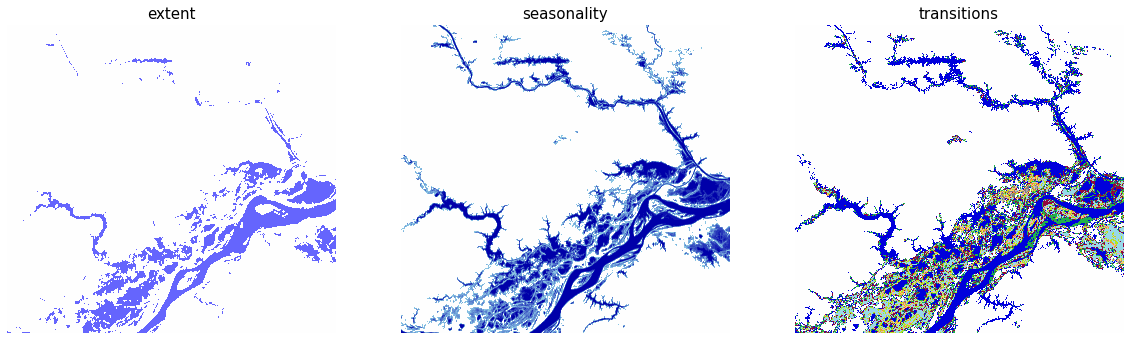

In [7]:
norm = Normalize(0, 255)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))

for i, asset_key in enumerate(assets_of_interest):
    ax[i].imshow(
        data.sel(band=asset_key),
        norm=norm,
        cmap=cmaps[asset_key],
    )
    ax[i].set_title(asset_key, fontdict={"fontsize": 15})
    ax[i].set_axis_off()

plt.show()

## Proximity Distance

The [xrspatial.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html) function takes a values aggregate as its input and computes a new distance aggregate. This computation is based on a set of `target_values` and a specific `distance_metric` within a `max_distance`. The `proximity` function uses this distance metric to calculate the distance at each array cell (pixel) in the values aggregate from the nearest of the target points. This smallest distance is set as each cell's value in the returned aggregate. Proximity distances greater than `max_distance` will be set to NaNs.

`xarray-spatial` also provides the [xrspatial.euclidean_distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.euclidean_distance.html), [xrspatial.great_circle_distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.great_circle_distance.html), and [xrspatial.manhattan_distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.manhattan_distance.html) functions to compute distances between two points using a specific metric, based ont the two points' coordinates. In this notebook, you'll consider the distance between point `p1=(-57.151965, -2.530125)` and point `p2=(-57.120526, -2.540378)`.

Calculate the proximity distance for the dataset's Maximum Water Extent asset. Use two different values for `max_distance`: the default infinite value and the Euclidean distance from `p1` to `p2`.

#### 1. Default options

By default, you'll use Euclidean as the `distance_metric`, the `target_values` parameter targets all non-zero pixels, and `max_distance` is set to infinity.

When scaling with Dask, whether the [xrspatial.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html) function scales well depends on the `max_distance` value. If `max_distance`  is infinite, this function only works on a single machine and you need to make sure that the input data fits the available memory. The function should scale well, however, if the `max_distance` is relatively small compared to the maximum possible distance in two arbitrary points in input raster. 

In [8]:
extent_data = data.sel(band="extent")

extent_proximity_default = proximity(extent_data)
extent_proximity_default.name = """
    Water Extent proximity distance
    (Euclidean max_distance=infinity)
"""

extent_proximity_default

<xarray.DataArray '\n    Water Extent proximity distance\n    (Euclidean max_distance=infinity)\n' (y: 5405, x: 5766)>
dask.array<rechunk-merge, shape=(5405, 5766), dtype=float64, chunksize=(3000, 3000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
    band            <U11 'extent'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    sci:doi         <U19 '10.1038/nature20584'
    ...              ...
    proj:transform  object {0.0, -0.00025, -60.0, 0.00025}
    start_datetime  object None
    proj:epsg       int64 4326
    description     <U74 'Binary indicator of whether water was ever present ...
    title           <U20 'Maximum Water Extent'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

Like many tools in xarray-spatial, the return values of the [xrspatial.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html) function is of the same type as the input type. This is also true for the other tools in xarray-spatial's proximity toolset. Since you supply a Dask-backed DataArray, the result is a non-computed Dask-backed DataArray.

#### 2. Finite max_distance

Calculate the Euclidean distance between points `p1` and `p2` using the [xrspatial.euclidean_distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.euclidean_distance.html) function:

In [9]:
from xrspatial import euclidean_distance

p1 = (-57.151965, -2.530125)
p2 = (-57.120526, -2.540378)

d_euclidean = euclidean_distance(p1[0], p2[0], p1[1], p2[1])
d_euclidean

0.03306863665166635

Compute the proximity distance using the Water Extent asset. Set `max_distance` to the value you calculated above. Note that the unit for `max_distance` needs to be the same as for `extent_data`.

In [10]:
extent_proximity = proximity(extent_data, max_distance=d_euclidean)

extent_proximity.name = f"""
    Water Extent proximity distance
    (Euclidean max_distance={d_euclidean:.5f})
"""

#### 3. Compare both results

After computing with both the infinite and finite settings for `max_distance`, compare the results by visualizing them next to each other:

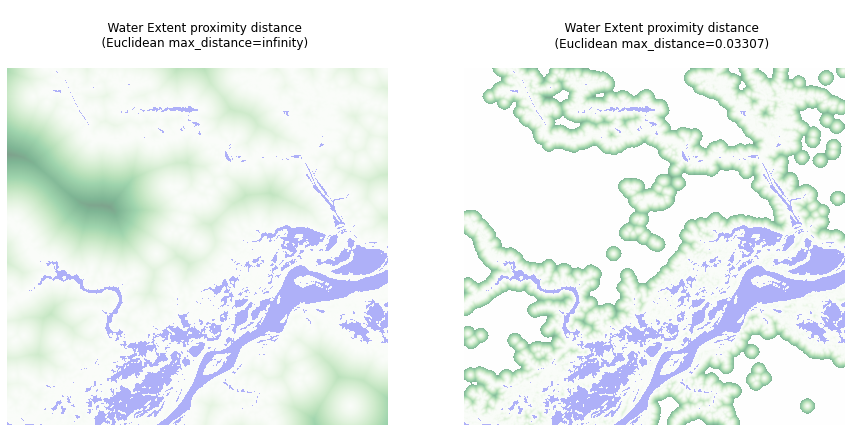

In [11]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(121)
plt.axis("off")
plt.imshow(extent_proximity_default, cmap="Greens")
plt.imshow(extent_data, norm=norm, cmap=cmaps["extent"], alpha=0.5)
plt.title(extent_proximity_default.name)

fig.add_subplot(122)
plt.axis("off")
plt.imshow(extent_proximity, cmap="Greens")
plt.imshow(extent_data, norm=norm, cmap=cmaps["extent"], alpha=0.5)
plt.title(extent_proximity.name)

plt.show()

In this visualization, dark green points are points that are further away from surface water, while lighter points are closer to surface water.

## Proximity Allocation

Similar to [xrspatial.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html), the [xrspatial.allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html) function takes an aggregate as its input and finds the smallest distance from each cell to any one of the target points or source points. However, instead of returning the distance, the [xrspatial.allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html) function returns the value at that source point and sets the current cell to that value. The result is a raster with block areas where all cells in each area are set to the value of that area's nearest source.

Calculate the allocation proximity for the dataset's Water Transitions asset data. This time, use the Great Circle distance metric and set `max_distance` to the Great Circle distance between `p1` and `p2`. Keep all non-zero target points active by not using the `target_values` parameter:

In [12]:
from xrspatial import great_circle_distance

d_great_circle = great_circle_distance(p1[0], p2[0], p1[1], p2[1])
d_great_circle

3677.9271626991012

Compute the allocation proximity of the Water Transitions asset data:

In [13]:
transitions_data = data.sel(band="transitions")

transitions_allocation = allocation(
    transitions_data, distance_metric="GREAT_CIRCLE", max_distance=d_great_circle
)
transitions_allocation.name = f"""
    Water Transitions proximity allocation
    (Great Circle max_distance={d_great_circle:.2f})
"""

Visualize the result:

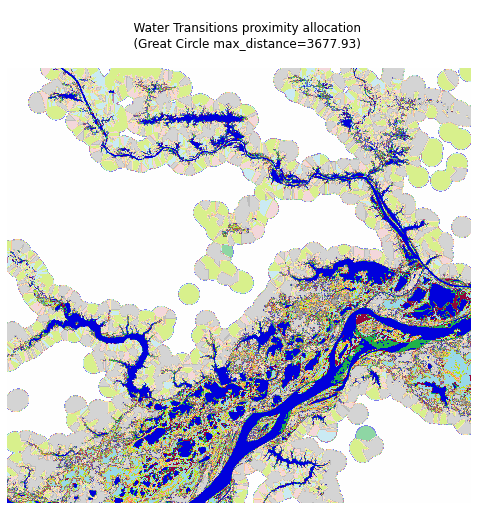

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.axis("off")
plt.imshow(transitions_allocation, norm=norm, cmap=cmaps["transitions"])
plt.imshow(transitions_data, norm=norm, cmap=cmaps["transitions"], alpha=0.5)
plt.title(transitions_allocation.name)
plt.show()

Notice the blocks in the visualization: each of the differently shaded blocks contains all of the points that share the target point in the center as their nearest target point.

## Proximity Direction

Once again, similar to [xrspatial.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html), the [xrspatial.direction](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.direction.html) function begins by calculating the smallest distance for each cell to a source point. Instead of returning the distance to that point, the `direction` function returns the direction in degrees to that nearest source point. The output values range from 0 to 360:
- 0 is for the source cell itself
- 90 is East
- 180 is South
- 270 is West
- 360 is North

Use [xrspatial.direction](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.direction.html) to calculate the proximity direction of areas that have at least ten months of water occurrence based on the dataset's Water Seasonality data.

This time, set `target_values` to `[10, 11, 12]` to calculate directions from pixels with a value of 10, 11, or 12. These values represent the number of months that surface water is present in that area. Use the Manhattan distance metric in this example. Similar to before, set `max_distance` to be the Manhattan distance between `p1` and `p2`:

In [15]:
from xrspatial import manhattan_distance

d_manhattan = manhattan_distance(p1[0], p2[0], p1[1], p2[1])
d_manhattan

0.04169199999999895

Calculate the proximity direction for the Water Seasonality asset data:

In [16]:
seasonality_direction = direction(
    data.sel(band="seasonality"),
    distance_metric="MANHATTAN",
    target_values=[10, 11, 12],
    max_distance=d_manhattan,
)

seasonality_direction.name = f"""
    10-12 months Water Seasonality proximity direction
    (Manhattan max_distance={d_manhattan:.5f})
"""

To better visualization all targets, filter out non-target pixels:

In [17]:
import copy

# for visualization purpose only
seasonality_data = copy.deepcopy(data.sel(band="seasonality"))
seasonality_data.data[seasonality_data.data < 10] = 0
seasonality_data.name = "Water Seasonality (10-12 months)"

Plot the seasonality data and the direction proximity data next to each other.

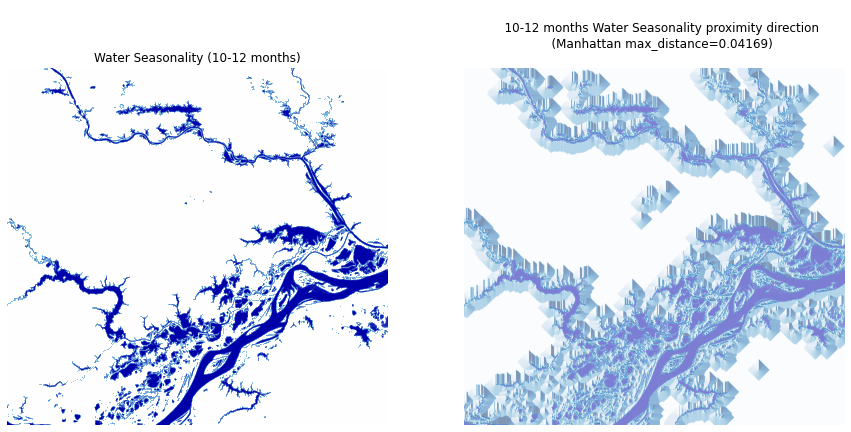

In [18]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(121)
plt.axis("off")
plt.imshow(seasonality_data, norm=norm, cmap=cmaps["seasonality"])
plt.title(seasonality_data.name)

fig.add_subplot(122)
plt.axis("off")
plt.imshow(seasonality_direction, cmap="Blues")
plt.imshow(seasonality_data, norm=norm, cmap=cmaps["seasonality"], alpha=0.5)
plt.title(seasonality_direction.name)

plt.show()

## Next steps: analyze more datasets

Try using Xarray-Spatial's [Proximity Distance](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Distance), [Proximity Allocation](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Allocation), and [Proximity Direction](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Direction) functions with different areas of interest and different assets of the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw). Or try using these tools with the [USGS GAP/LANDFIRE National Terrestrial Ecosystems dataset](https://planetarycomputer.microsoft.com/dataset/gap) to analyze proximity distances between different kinds of landcovers.